<a href="https://colab.research.google.com/github/qaz027/Dojo_project2/blob/main/Project2_part5_boosting_and_neural_networks_quimby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Kaggle has a heart disease dataset that incorporates patient information to predict prevalance of heart disease.
It is 918 observations with 11 features and the heart disease target.

https://www.kaggle.com/fedesoriano/heart-failure-prediction

This would be a classification problem. 
Not a whole lot in the way of cleaning and modeling. Just working through the various models, tuning, and determining the best model for prediction


In [42]:
import pandas as pd
import numpy as np

#viz
import seaborn as sns
import matplotlib.pyplot as plt

#model preprocessing
from sklearn.model_selection import train_test_split
# import pipeline creator
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

#reporting
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

#classfication models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Read in Data and clean

In [167]:
infile = '/content/drive/MyDrive/Coding/Dojo - Data Science/heart.csv'
heart = pd.read_csv(infile)
print(heart.head())

   Age Sex ChestPainType  ...  Oldpeak  ST_Slope  HeartDisease
0   40   M           ATA  ...      0.0        Up             0
1   49   F           NAP  ...      1.0      Flat             1
2   37   M           ATA  ...      0.0        Up             0
3   48   F           ASY  ...      1.5      Flat             1
4   54   M           NAP  ...      0.0        Up             0

[5 rows x 12 columns]


To meet the requirements for this week you must have:

-deleted unnecessary columns

-deleted duplicate rows

-identified and addressed missing values 

-identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats)

-produced univariate visuals for the target and all features

-identified outliers

-produce a correlation heatmap and identify any moderate or strong correlations between your target and your features and/or between one feature and another

-clearly commented all of your cleaning steps and described any decisions you made  (Note: During the final stack of the program, you will be making a presentation for a technical audience that includes your decisions and process in the cleaning steps. The more notes you take now, the easier that presentation will be. To clarify, that presentation is NOT due now.)

Note that you should start working on your in depth EDA and making multivariate visuals for the upcoming part 3 of this assignment once you have submitted all tasks and your belt exam for this stack.

In [97]:
print(heart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [98]:
heart.duplicated().sum()

0

In [99]:
heart['Sex'].unique()

array(['M', 'F'], dtype=object)

In [100]:
heart['ChestPainType'].unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [101]:
heart['RestingECG'].unique()

array(['Normal', 'ST', 'LVH'], dtype=object)

In [102]:
heart['ExerciseAngina'].unique()

array(['N', 'Y'], dtype=object)

In [103]:
heart['ST_Slope'].unique()

array(['Up', 'Flat', 'Down'], dtype=object)

In [104]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [114]:
#create different data on cholesterol and see results:
heart['Cholesterol'].replace(0,604, inplace=True)
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,311.967320,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,150.091237,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,254.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,320.750000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,604.000000,1.000000,202.000000,6.200000,1.000000


In [115]:
heart[heart['Oldpeak']<0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
321,63,M,ASY,100,604,1,Normal,109,N,-0.9,Flat,1
324,46,M,ASY,100,604,1,ST,133,N,-2.6,Flat,1
325,42,M,ASY,105,604,1,Normal,128,Y,-1.5,Down,1
326,45,M,NAP,110,604,0,Normal,138,N,-0.1,Up,0
331,56,M,ASY,115,604,1,ST,82,N,-1.0,Up,1
332,38,M,NAP,100,604,0,Normal,179,N,-1.1,Up,0
334,51,M,ASY,130,604,1,Normal,170,N,-0.7,Up,1
335,62,M,TA,120,604,1,LVH,134,N,-0.8,Flat,1
352,56,M,ASY,120,604,0,ST,100,Y,-1.0,Down,1
407,62,M,ASY,115,604,1,Normal,72,Y,-0.5,Flat,1


# Initial Viz

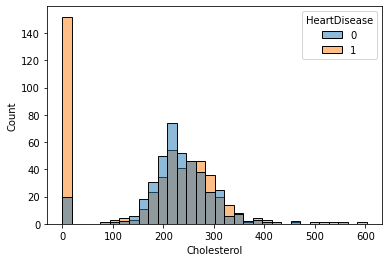

In [17]:
sns.histplot(data=heart,x='Cholesterol', hue='HeartDisease')

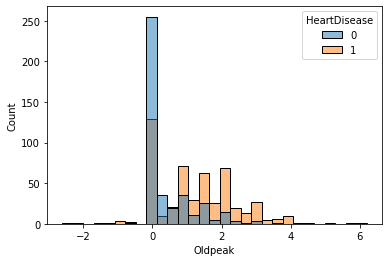

In [29]:
sns.histplot(data=heart,x='Oldpeak', hue='HeartDisease')

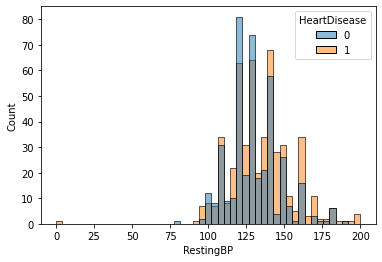

In [30]:
sns.histplot(data=heart,x='RestingBP', hue='HeartDisease')

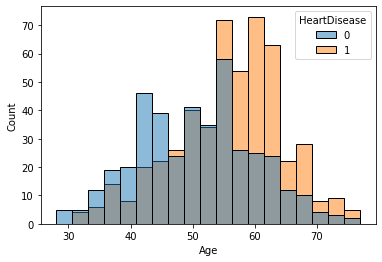

In [16]:
sns.histplot(data=heart,x='Age', hue='HeartDisease')

In [ ]:
#heart['MissingCholesterol']=heart['Cholesterol']==0

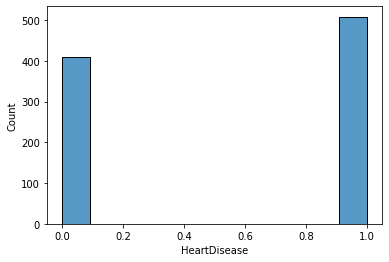

In [ ]:
#histogram of HeartDisease Target
sns.histplot(data=heart, x='HeartDisease')

In [ ]:
heart['HeartDisease'].value_counts(normalize=True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

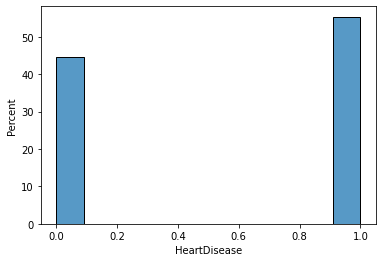

In [ ]:
sns.histplot(data=heart, x='HeartDisease', stat='percent')

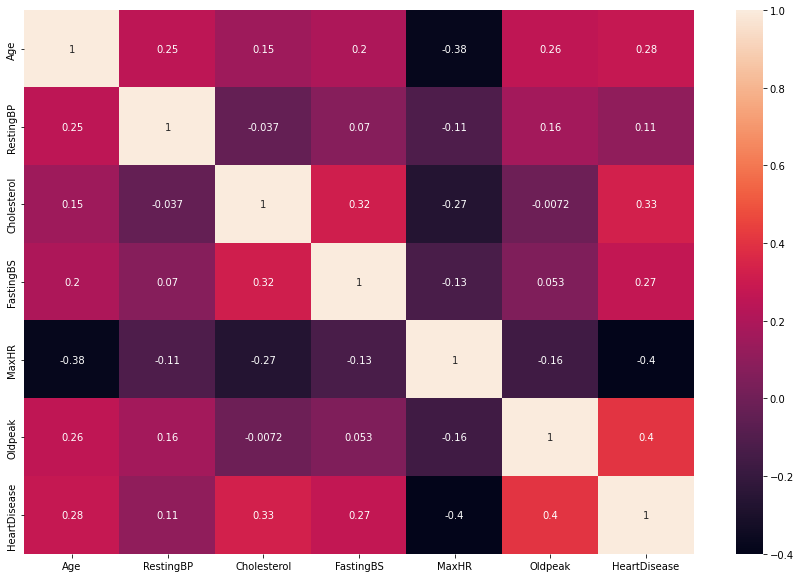

In [45]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(heart.corr(), annot=True, ax=ax)

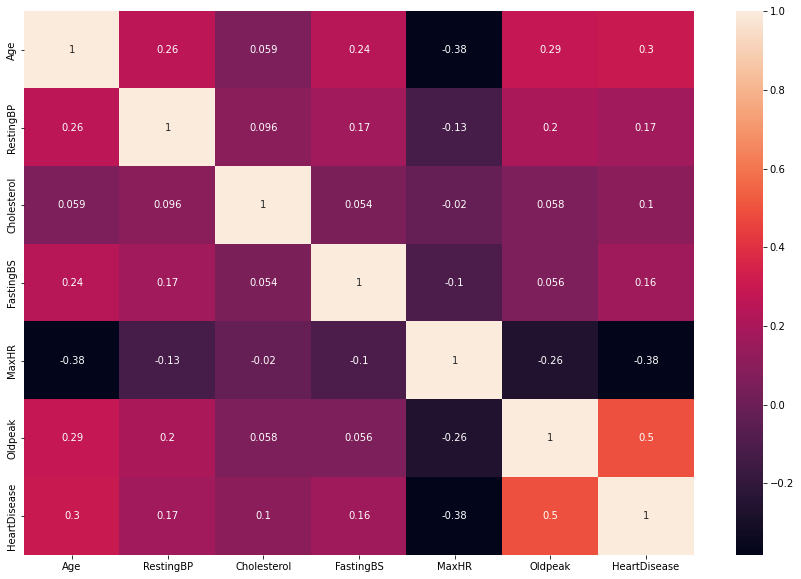

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cholesterol.corr(), annot=True, ax=ax)

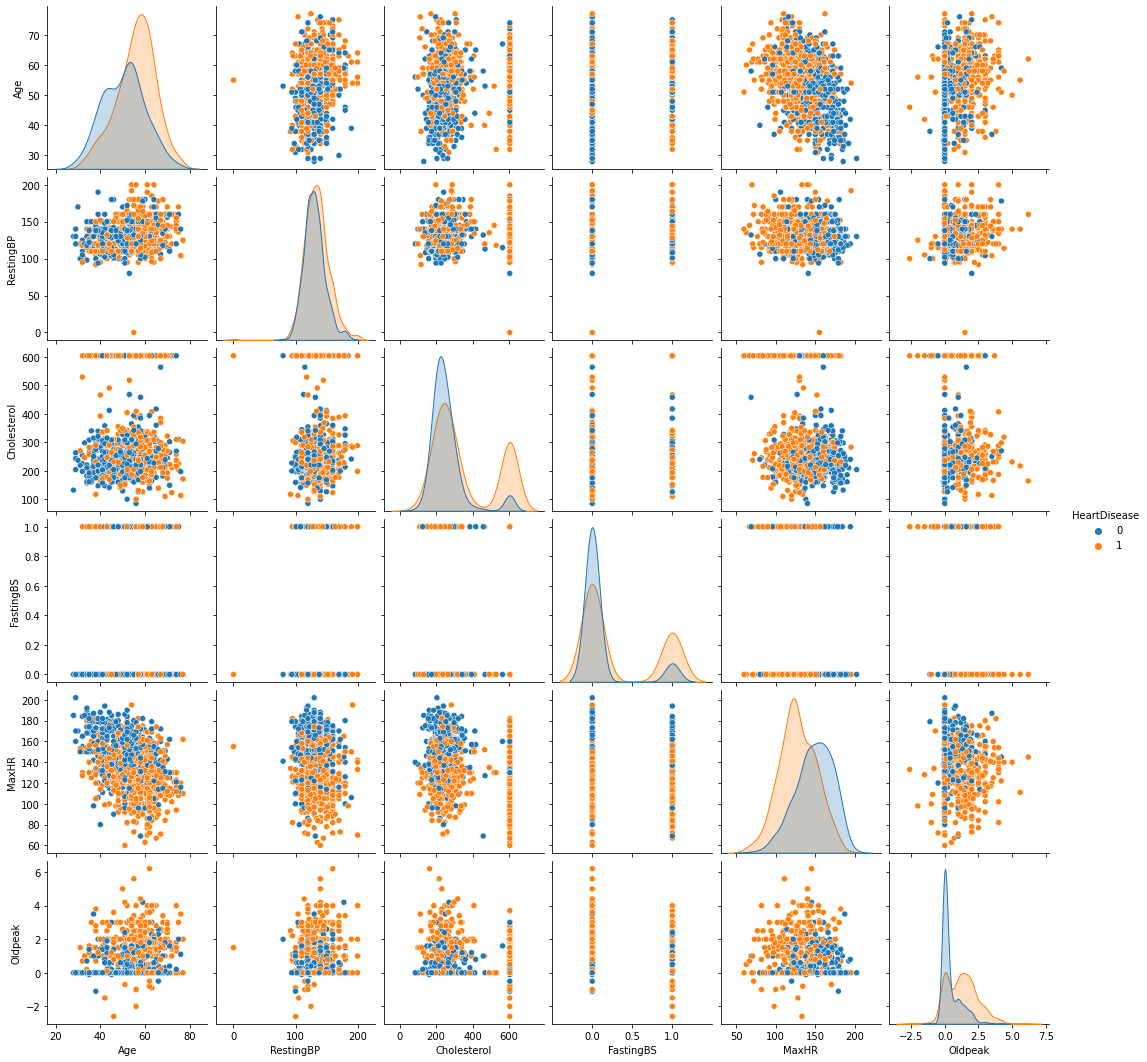

In [46]:
sns.pairplot(heart,hue='HeartDisease')

# Additional Viz & Clustering

In [47]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


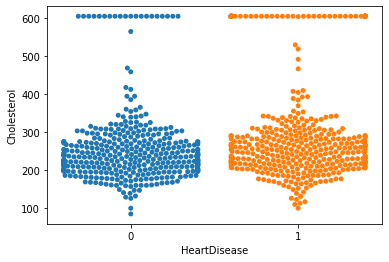

In [48]:
sns.swarmplot(data=heart, y='Cholesterol', x='HeartDisease')

In [49]:
x=np.array(heart['Age'])
y=np.array(heart['Cholesterol'])
z=np.array(heart['MaxHR'])
clusters = np.array(heart['HeartDisease'])

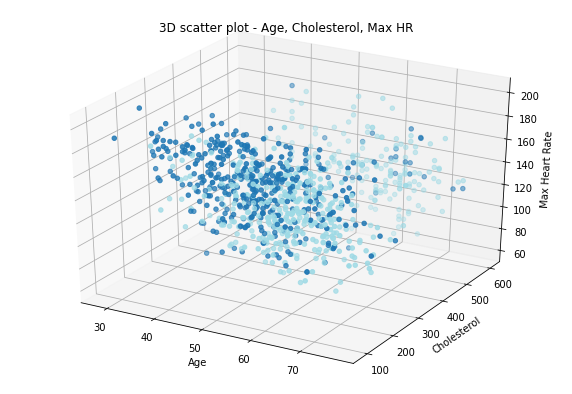

In [50]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, c=clusters, cmap = "tab20")
plt.title("3D scatter plot - Age, Cholesterol, Max HR")
ax.set_xlabel('Age')
ax.set_ylabel('Cholesterol')
ax.set_zlabel('Max Heart Rate')
 
# show plot
plt.show()

In [51]:
ohe = OneHotEncoder()
scaler = StandardScaler()

#column_selectors to tell the column transformers which columns to apply which preprocessing to
category_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number')

#list of (transformer, columns) tuples
transformers = [(ohe, category_selector), (scaler, number_selector)]

#column transformer
column_transformer = make_column_transformer((ohe, category_selector), (scaler, number_selector))

#create a preprocessing pipeline to add to a later estimator pipeline
preprocessing_pipeline = make_pipeline(column_transformer)

In [52]:
#use all the data to cluster
hr = heart.drop(columns=['HeartDisease'])
hr_pipe = make_pipeline(preprocessing_pipeline)
hr2 = hr_pipe.fit_transform(hr)

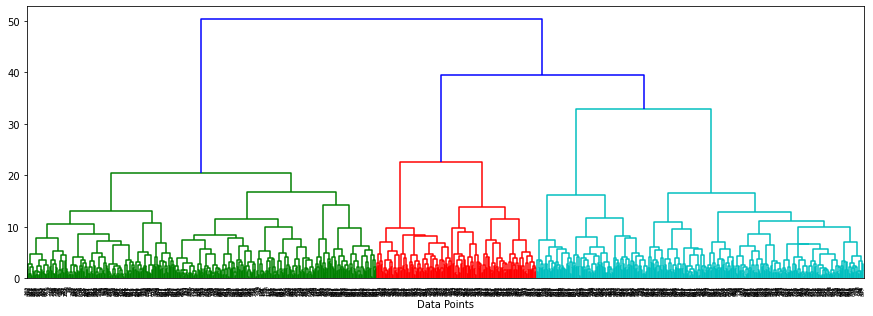

In [53]:
plt.figure(figsize = (15, 5))
sch.dendrogram(sch.linkage(hr2, method = 'ward'))
plt.xlabel('Data Points');


#More Viz

In [116]:
hr3 = pd.get_dummies(heart,drop_first=True)
hr3_sc = scaler.fit_transform(hr3)

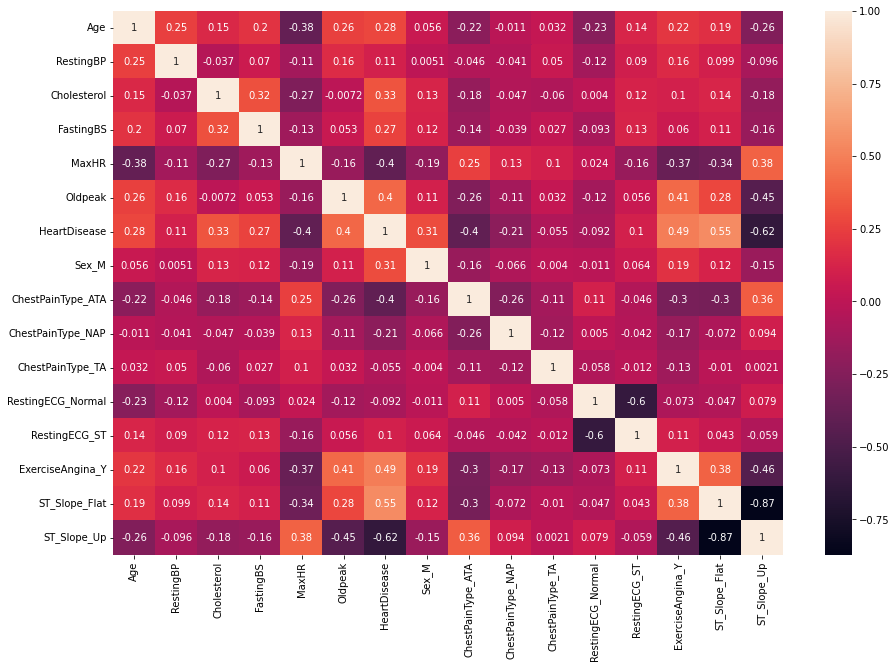

In [117]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(hr3.corr(), annot=True, ax=ax)

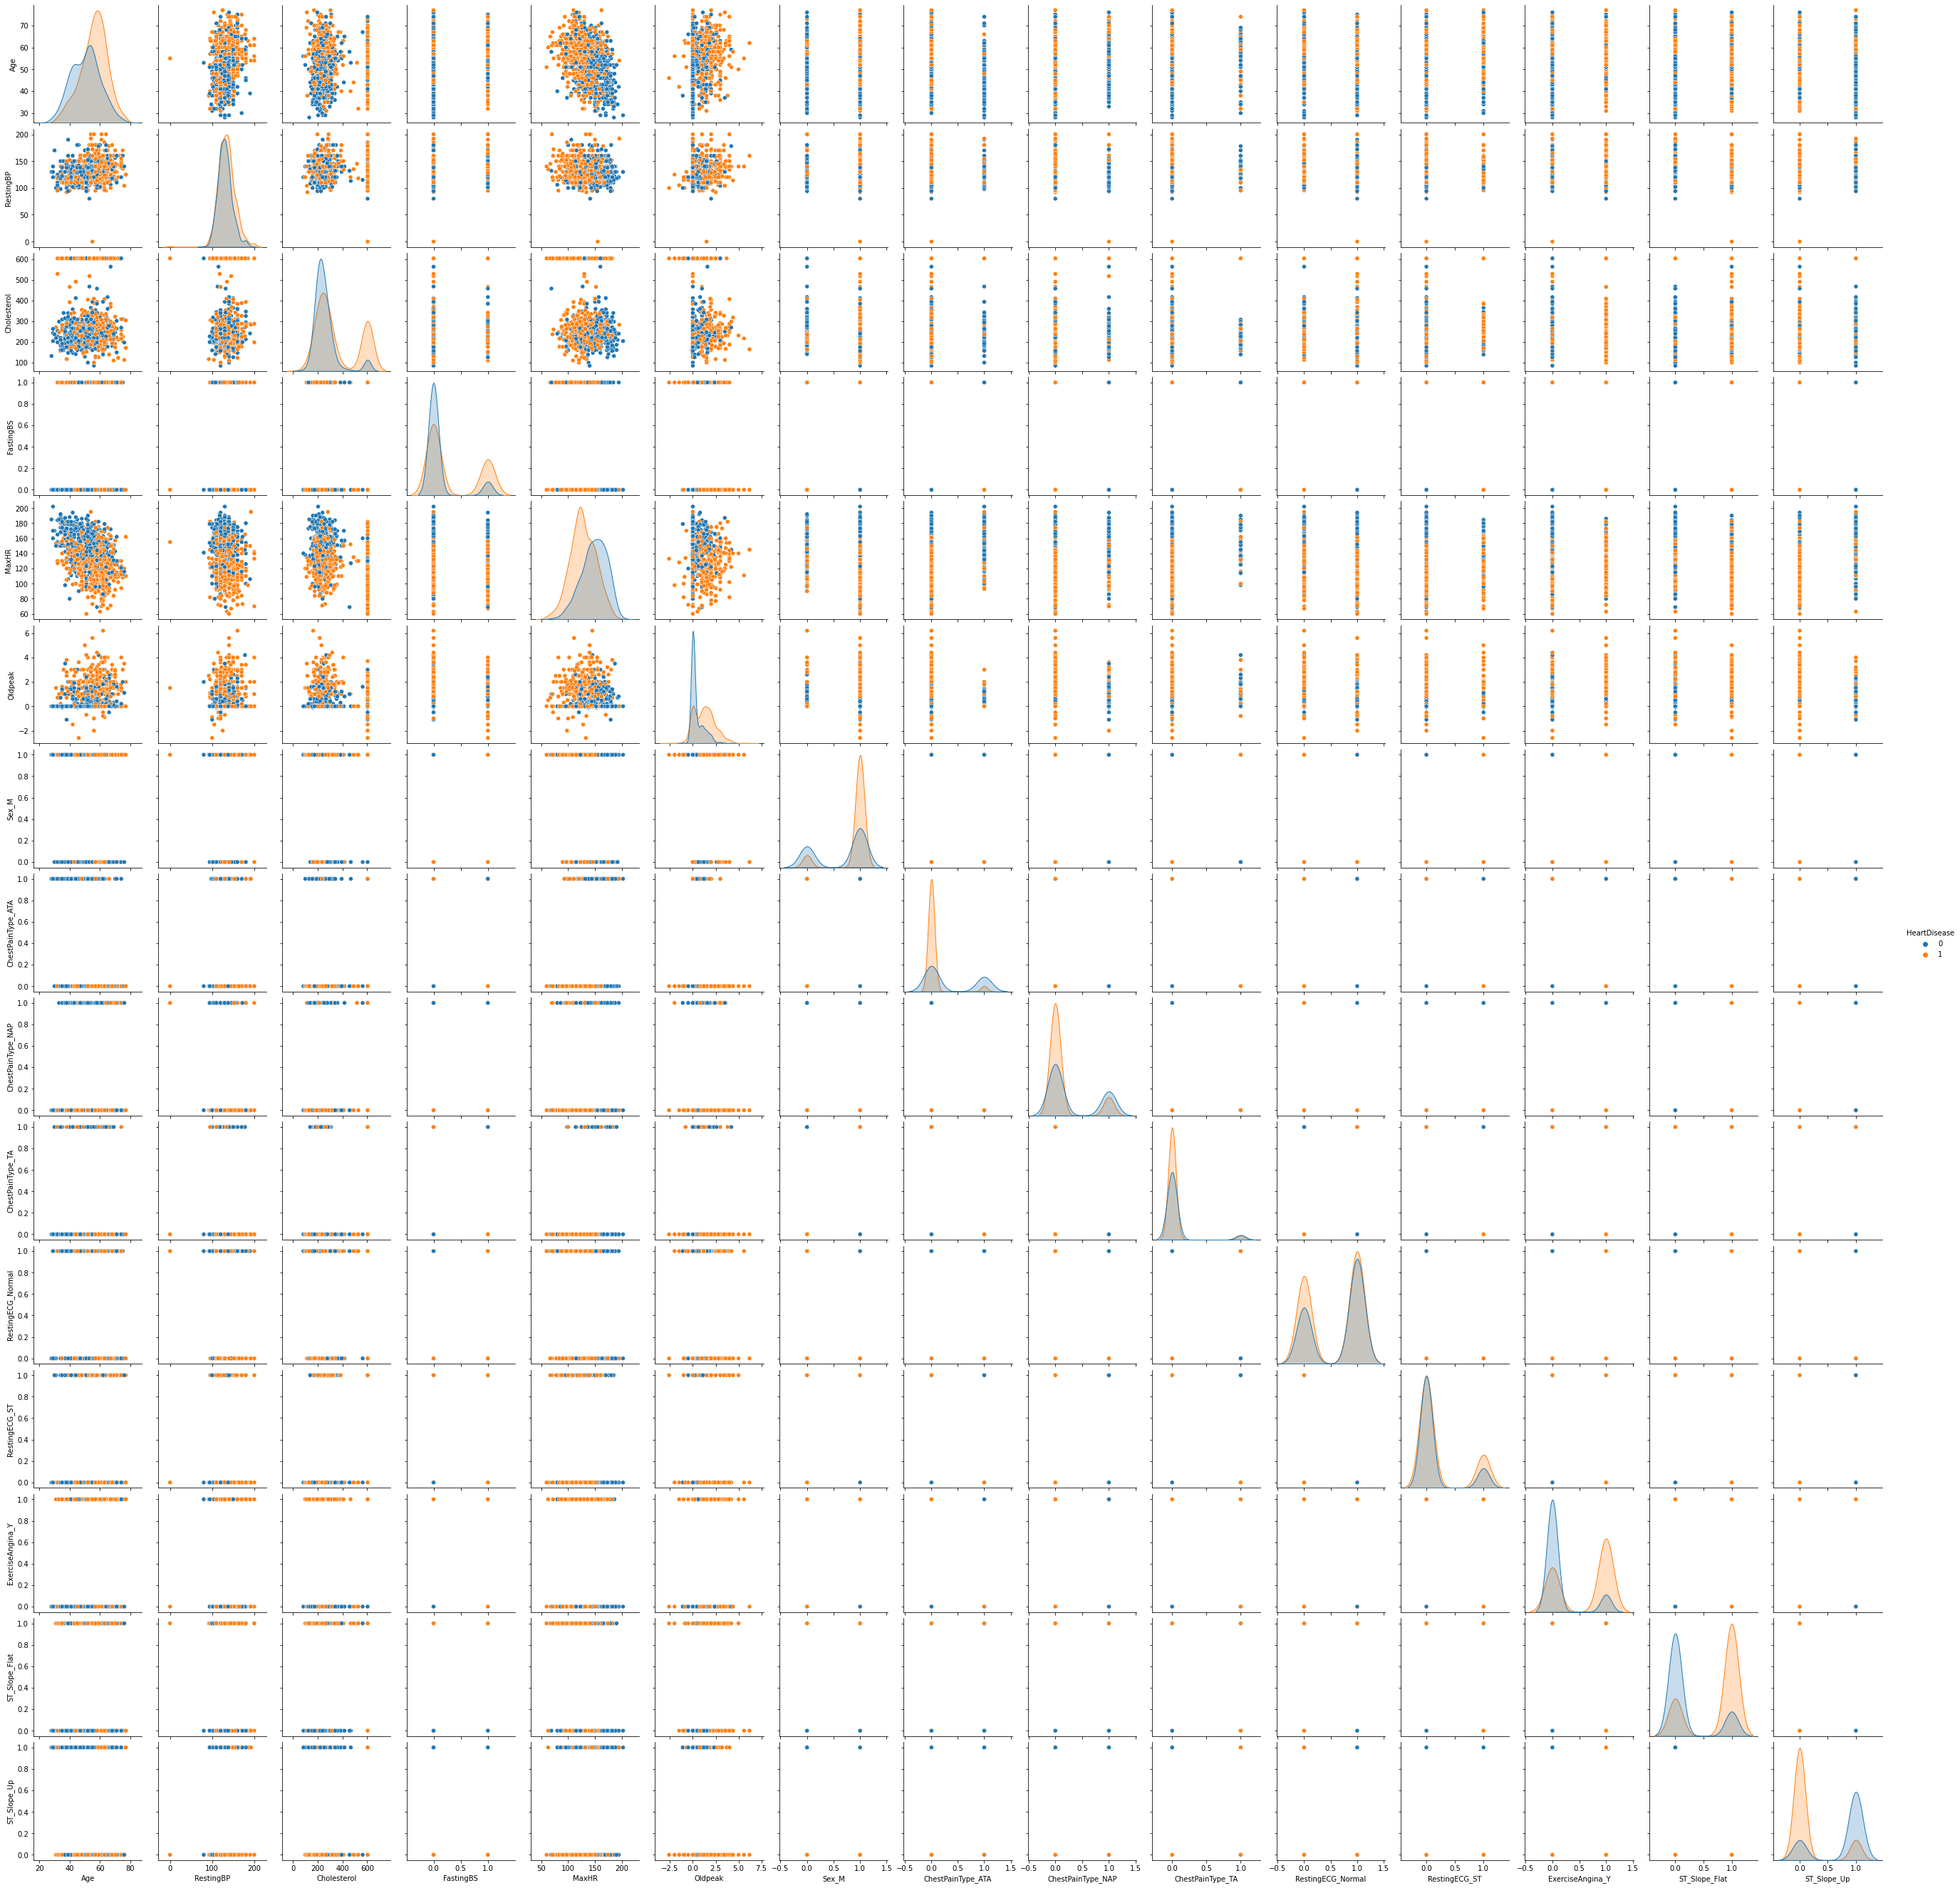

In [95]:
sns.pairplot(hr3, hue='HeartDisease')

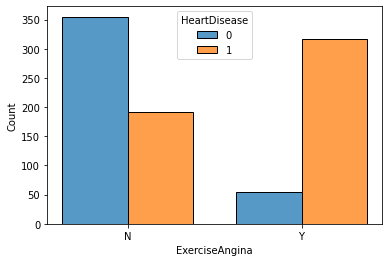

In [134]:
sns.histplot(data=heart,x='ExerciseAngina', hue='HeartDisease', multiple='dodge', shrink=0.75);

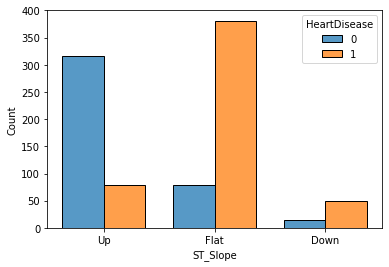

In [123]:
sns.histplot(data=heart,x='ST_Slope', hue='HeartDisease', multiple='dodge', shrink=0.75)

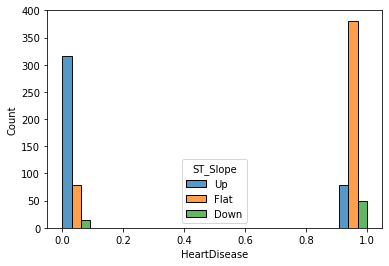

In [124]:
sns.histplot(data=heart, x='HeartDisease', hue='ST_Slope', multiple='dodge')

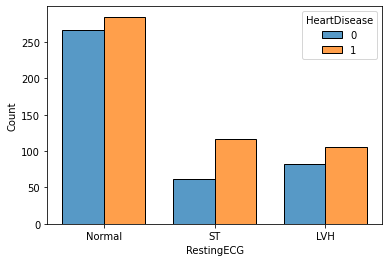

In [133]:
sns.histplot(data=heart,x='RestingECG', hue='HeartDisease', multiple='dodge', shrink=0.75);

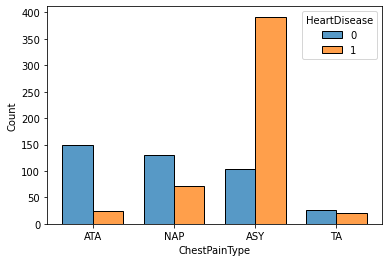

In [132]:
sns.histplot(data=heart,x='ChestPainType', hue='HeartDisease', multiple='dodge', shrink=0.75);

In [150]:
heart[(heart['Oldpeak']<1) & (heart['Oldpeak']>0)].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,55.576271,131.881356,317.305085,0.271186,141.957627,0.446610,0.389831
std,8.400658,17.809135,156.074687,0.446468,23.028186,0.243438,0.489791
min,32.000000,95.000000,126.000000,0.000000,63.000000,0.100000,0.000000
25%,51.000000,120.000000,215.000000,0.000000,127.250000,0.200000,0.000000
50%,57.000000,130.000000,253.000000,0.000000,142.000000,0.500000,0.000000
75%,60.750000,140.000000,341.500000,1.000000,157.000000,0.600000,1.000000
max,74.000000,180.000000,604.000000,1.000000,194.000000,0.900000,1.000000


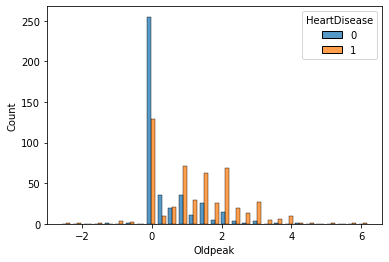

In [142]:
sns.histplot(data=heart,x='Oldpeak', hue='HeartDisease', multiple='dodge', shrink=0.75);

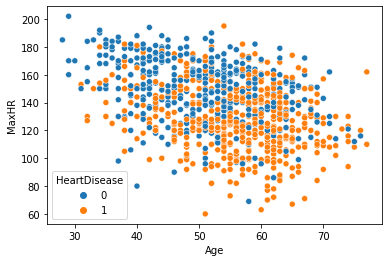

In [160]:
sns.scatterplot(data=heart,x='Age', y='MaxHR', hue='HeartDisease')

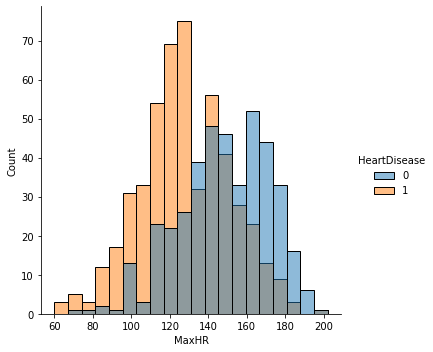

In [163]:
sns.displot(data=heart, x='MaxHR',hue='HeartDisease');

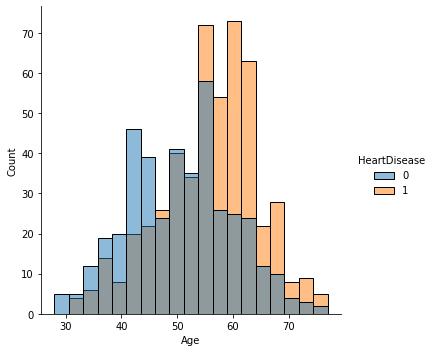

In [165]:
sns.displot(data=heart, x='Age',hue='HeartDisease');

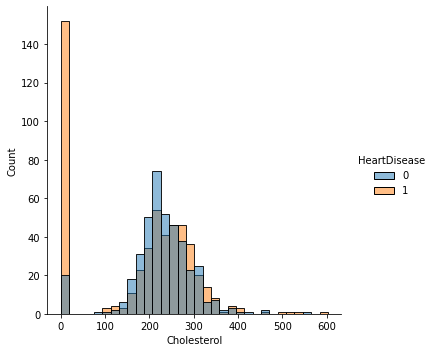

In [168]:
sns.displot(data=heart, x='Cholesterol',hue='HeartDisease');

# Model Selection

In [61]:
def make_confmat(y_true, y_pred, labels=None, savepath=None, cmap='Greens',
                 normalize='true'):
  conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize)
  figure = sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, 
                       annot=True, cmap=cmap)
  if savepath:
    plt.savefig(savepath)
  return figure

labels = ['No Disease','Heart Disease']

In [62]:
#avg incidence in dataset is 55.34%
pca = PCA()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
logit = LogisticRegression()

In [63]:
knn_pipe = make_pipeline(preprocessing_pipeline, pca, knn)
rf_pipe = make_pipeline(preprocessing_pipeline, pca, rf)
log_pipe = make_pipeline(preprocessing_pipeline, pca, logit)


In [64]:
y = heart['HeartDisease']
X = heart.drop(columns='HeartDisease')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

y_train.mean()

0.5465116279069767

Baseline prediction for the model is 54.7%

KNN Results

------------------------------------

Training accuracy: 0.877906976744186
Testing accuracy: 0.8695652173913043


              precision    recall  f1-score   support

           0       0.83      0.87      0.85        98
           1       0.90      0.87      0.88       132

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230



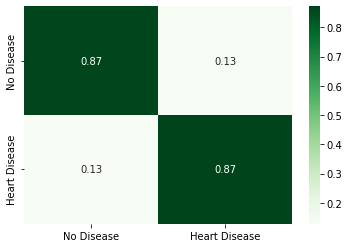

In [65]:
#KNN analysis
print('KNN Results\n')
print('------------------------------------\n')
knn_pipe.fit(X_train,y_train)
print('Training accuracy:', knn_pipe.score(X_train, y_train))
print('Testing accuracy:', knn_pipe.score(X_test, y_test))
print('\n')
y_hat = knn_pipe.predict(X_test)

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

Random Forest Classification Results

------------------------------------

Training accuracy: 1.0
Testing accuracy: 0.8869565217391304


              precision    recall  f1-score   support

           0       0.87      0.87      0.87        98
           1       0.90      0.90      0.90       132

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230



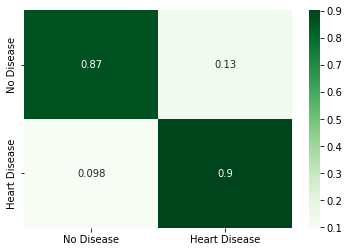

In [66]:
#RF
rf_pipe.fit(X_train,y_train)
print('Random Forest Classification Results\n')
print('------------------------------------\n')
print('Training accuracy:', rf_pipe.score(X_train, y_train))
print('Testing accuracy:', rf_pipe.score(X_test, y_test))
print('\n')

y_hat = rf_pipe.predict(X_test)
print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

Logistic Regression Results

------------------------------------

Training accuracy: 0.877906976744186
Testing accuracy: 0.8695652173913043


              precision    recall  f1-score   support

           0       0.83      0.87      0.85        98
           1       0.90      0.87      0.88       132

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230



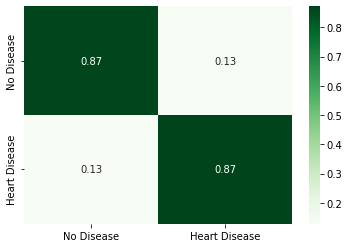

In [67]:
#logistic regression
log_pipe.fit(X_train,y_train)
print('Logistic Regression Results\n')
print('------------------------------------\n')
print('Training accuracy:', log_pipe.score(X_train, y_train))
print('Testing accuracy:', log_pipe.score(X_test, y_test))
print('\n')

y_hat = log_pipe.predict(X_test)
print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

# HyperTuning Models

In [68]:
params = {'randomforestclassifier__n_estimators': [10, 50, 100, 200, 300, 400, 500],
          'randomforestclassifier__max_depth': [None, 2, 3, 4, 5],
          'randomforestclassifier__min_samples_split': [2, 3],
          'randomforestclassifier__min_samples_leaf': [1,2]}

gs = GridSearchCV(rf_pipe, param_grid = params)
gs.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pipeline',
                                        Pipeline(memory=None,
                                                 steps=[('columntransformer',
                                                         ColumnTransformer(n_jobs=None,
                                                                           remainder='drop',
                                                                           sparse_threshold=0.3,
                                                                           transformer_weights=None,
                                                                           transformers=[('onehotencoder',
                                                                                          OneHotEncoder(categories='auto',
                                                                                                        drop=None,


In [69]:
gs.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 300}

Random Forest Classification Results - Grid Search

--------------------------------------------------

Training accuracy:  1.0
Testing accuracy:  0.8782608695652174
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        98
           1       0.90      0.89      0.89       132

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



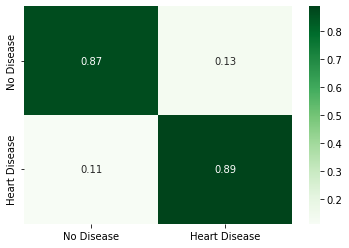

In [70]:
print('Random Forest Classification Results - Grid Search\n')
print('--------------------------------------------------\n')
print("Training accuracy: ", gs.score(X_train, y_train))
print("Testing accuracy: ", gs.score(X_test,y_test))
y_hat = gs.predict(X_test)

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

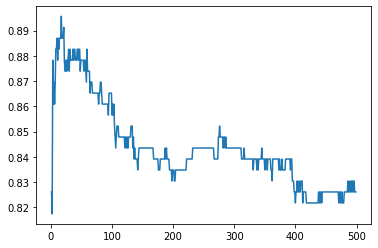

Best K value is 17 
with 0.8956521739130435 accuracy on the test set


In [71]:
krange = range(1, 500)
test_accuracies = []
bestacc = 0
bestk = 0
for k in krange:
  #find accuracy for each k
  pipe = make_pipeline(preprocessing_pipeline, pca, KNeighborsClassifier(n_neighbors=k))
  pipe.fit(X_train, y_train)
  acc = accuracy_score(y_test, pipe.predict(X_test))
  #if accuracy for this k is better than previous accuracies, set bestk = k
  if acc > bestacc:
    bestacc = acc
    bestk = k

  test_accuracies.append(acc)

#plot accuracies over K
plt.plot(krange, test_accuracies, label='Test K Scores')
plt.show()

#print best k and best accuracy
print(f'Best K value is {bestk} \nwith {bestacc} accuracy on the test set')

KNN Classification Results - Grid Search

--------------------------------------------------

Training accuracy:  0.877906976744186
Testing accuracy:  0.8956521739130435
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        98
           1       0.91      0.91      0.91       132

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



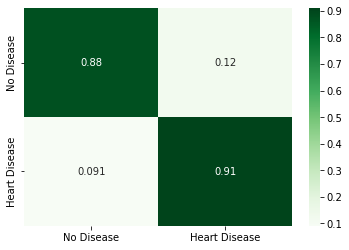

In [72]:
#Optimized KNN
knn_pipe = make_pipeline(preprocessing_pipeline, pca, KNeighborsClassifier(n_neighbors=bestk))
knn_pipe.fit(X_train, y_train)
y_hat = knn_pipe.predict(X_test)

print('KNN Classification Results - Grid Search\n')
print('--------------------------------------------------\n')
print("Training accuracy: ", knn_pipe.score(X_train, y_train))
print("Testing accuracy: ", knn_pipe.score(X_test,y_test))

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

In [73]:
log_pipe

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('columntransformer',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='error',
                                                                           

In [74]:
params = {"logisticregression__penalty": ['l1','l2'],
          "logisticregression__C":np.logspace(-3,3,7),
          "logisticregression__max_iter" : [100,250,500,1000],
          "logisticregression__solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs = GridSearchCV(log_pipe, param_grid = params);
gs.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/skle

In [75]:
gs.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'newton-cg'}

Logistic Regression Results - Grid Search

--------------------------------------------------

Training accuracy:  0.8822674418604651
Testing accuracy:  0.8826086956521739
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        98
           1       0.90      0.89      0.90       132

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



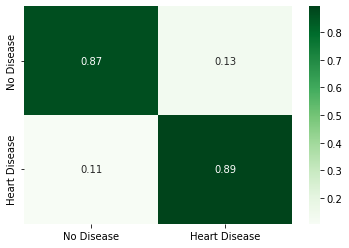

In [76]:
print('Logistic Regression Results - Grid Search\n')
print('--------------------------------------------------\n')
print("Training accuracy: ", gs.score(X_train, y_train))
print("Testing accuracy: ", gs.score(X_test,y_test))
y_hat = gs.predict(X_test)

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

#Boosting Methods

Training accuracy: 0.9316860465116279
Testing accuracy: 0.8782608695652174
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        98
           1       0.91      0.87      0.89       132

    accuracy                           0.88       230
   macro avg       0.87      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



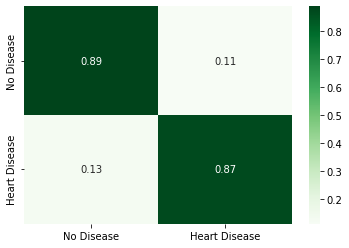

In [78]:
#XGB
xgb_pipe = make_pipeline(preprocessing_pipeline, XGBClassifier())
xgb_pipe.fit(X_train, y_train)
y_hat = xgb_pipe.predict(X_test)
print('Training accuracy:', xgb_pipe.score(X_train, y_train))
print('Testing accuracy:', xgb_pipe.score(X_test, y_test))

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

Training accuracy: 0.936046511627907
Testing accuracy: 0.8521739130434782
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        98
           1       0.92      0.82      0.86       132

    accuracy                           0.85       230
   macro avg       0.85      0.86      0.85       230
weighted avg       0.86      0.85      0.85       230



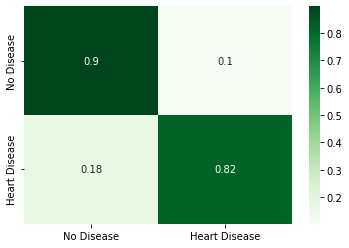

In [79]:
xgb_pipe = make_pipeline(preprocessing_pipeline, pca, XGBClassifier())
xgb_pipe.fit(X_train, y_train)
y_hat = xgb_pipe.predict(X_test)
print('Training accuracy:', xgb_pipe.score(X_train, y_train))
print('Testing accuracy:', xgb_pipe.score(X_test, y_test))

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

Training accuracy: 1.0
Testing accuracy: 0.8739130434782608
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        98
           1       0.90      0.88      0.89       132

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230



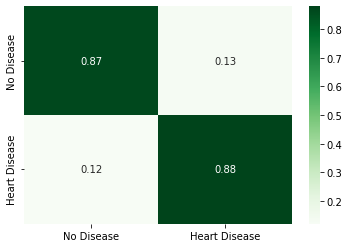

In [80]:
#LGBM
lgb_pipe = make_pipeline(preprocessing_pipeline, LGBMClassifier())
lgb_pipe.fit(X_train, y_train)
y_hat = lgb_pipe.predict(X_test)
print('Training accuracy:', lgb_pipe.score(X_train, y_train))
print('Testing accuracy:', lgb_pipe.score(X_test, y_test))

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

Training accuracy: 0.9840116279069767
Testing accuracy: 0.8652173913043478
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        98
           1       0.92      0.84      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



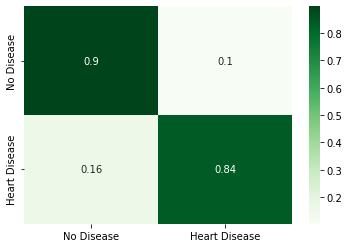

In [81]:
#LGBM
lgb_pipe = make_pipeline(preprocessing_pipeline, pca, LGBMClassifier())
lgb_pipe.fit(X_train, y_train)
y_hat = lgb_pipe.predict(X_test)
print('Training accuracy:', lgb_pipe.score(X_train, y_train))
print('Testing accuracy:', lgb_pipe.score(X_test, y_test))

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

#Neural Networks

In [82]:
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

In [83]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [84]:
sc_pipe = make_pipeline(preprocessing_pipeline)
X_train_sc = sc_pipe.fit_transform(X_train)
X_test_sc = sc_pipe.transform(X_test)


In [85]:
model = Sequential()

In [87]:
model.add(Dense(10, input_shape=((X_train_sc.shape[1],)), activation='sigmoid'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [88]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1000)              11000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               100100    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0

In [89]:
history = model.fit(X_train_sc, y_train,
                    validation_data=(X_test_sc, y_test),
                    epochs = 100)

Epoch 1/100
22/22 [==============================] - 2s 15ms/step - loss: 1.0068 - acc: 0.5451 - val_loss: 0.7020 - val_acc: 0.5739
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.7083 - acc: 0.5465 - val_loss: 0.6805 - val_acc: 0.5739
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.6947 - acc: 0.5451 - val_loss: 0.6804 - val_acc: 0.5739
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.6894 - acc: 0.5494 - val_loss: 0.6797 - val_acc: 0.5739
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.6922 - acc: 0.5465 - val_loss: 0.6776 - val_acc: 0.5739
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.6808 - acc: 0.5494 - val_loss: 0.6676 - val_acc: 0.5739
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.6657 - acc: 0.5465 - val_loss: 0.6247 - val_acc: 0.5739
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.6191 - 

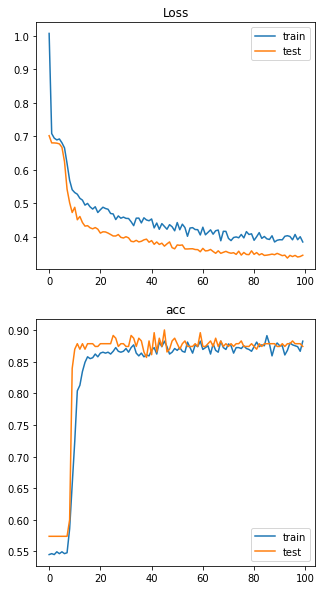

In [90]:
plot_history(history, 'acc')

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        98
           1       0.92      0.86      0.89       132

    accuracy                           0.87       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.88      0.87      0.87       230



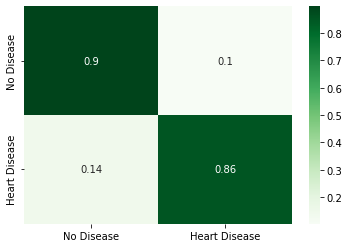

In [91]:
y_hat = np.rint(model.predict(X_test_sc))
print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

# Final Model Selection - KNN

Based on the model results, the KNN model (bestK neighbors = 17) provided the best results - strong accuracy, low bias, and least amount of false positives and false negatives among the options tested.

KNN Classification Results - Grid Search

--------------------------------------------------

Training accuracy:  0.877906976744186
Testing accuracy:  0.8956521739130435
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        98
           1       0.91      0.91      0.91       132

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



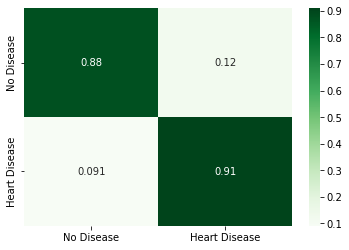

In [156]:
#Final Model
knn_pipe = make_pipeline(preprocessing_pipeline, pca, KNeighborsClassifier(n_neighbors=bestk))
knn_pipe.fit(X_train, y_train)
y_hat = knn_pipe.predict(X_test)

print('KNN Classification Results - Grid Search\n')
print('--------------------------------------------------\n')
print("Training accuracy: ", knn_pipe.score(X_train, y_train))
print("Testing accuracy: ", knn_pipe.score(X_test,y_test))

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels)
conf_mat

#Appendix: Analyzing Cholesterol data

In [18]:
heart[heart['Cholesterol']>0].mean()


Age              52.882038
RestingBP       133.022788
Cholesterol     244.635389
FastingBS         0.167560
MaxHR           140.226542
Oldpeak           0.901609
HeartDisease      0.477212
dtype: float64

In [19]:
heart[heart['Cholesterol']==0].mean()

Age              56.238372
RestingBP       129.680233
Cholesterol       0.000000
FastingBS         0.517442
MaxHR           121.988372
Oldpeak           0.825581
HeartDisease      0.883721
dtype: float64

In [22]:
heart[heart['Cholesterol']>=500].mean()

Age              51.50
RestingBP       127.00
Cholesterol     553.50
FastingBS         0.25
MaxHR           136.25
Oldpeak           0.65
HeartDisease      0.75
dtype: float64

In [24]:
heart[heart['Cholesterol']>=500]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
149,54,M,ASY,130,603,1,Normal,125,Y,1.0,Flat,1
616,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0
